In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import altair as alt
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import teotil3 as teo
from geopy.distance import geodesic
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part B: Compare to measured fluxes

This notebook compares output from the TEOTIL3 model with observed datasets.

## 1. Generate input files

The code below generates model input files from the "raw" data in the TEOTIL3 database.

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
agri_loss_model = "annual"  # 'annual' or 'risk'
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [5]:
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, "test_new_ss_coeffs", f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss.csv"
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,903.5,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,125.911370,269.972783,3.420677,6341.957245,69.787520,195.698890,3.609359,0.188682,...,5.6,1318.1,34149.0,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,45.071677,0.117126,464.712744,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,6168.8,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,12525.3,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,125.4,0.1,1386.1,25.9,30.9,0.8,0.7,2013


## 3. Compare to measured data

### 3.1. Discharge

Since many of the nutrient fluxes in TEOTIL3 are linked to runoff, it is import the model produces sensible estimates of discharge.

#### 3.1.1. Data for all NVE stations

As a general test, the code in this section downloads all discharge data available from NVE's HydAPI within the period of interest. This is a coarse approach and there are likely lots of edge cases where the model will perform badly, but it should neverless give a broad indications of the model's performance across a range of spatial scales and geographic regions. 

In [6]:
# Define stations, parameters and time period of interest
par_ids = [1001]  # Discharge
st_dt = f"{st_yr}-01-01"
end_dt = f"{end_yr}-12-31"

In [7]:
# List all stations
stn_df = nivapy.da.get_nve_hydapi_stations()
print(len(stn_df), "stations available.")
stn_df.head()

1870 stations available.


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
0,1.15.0,Femsjø,59.13015,11.48516,298887,6559841,81,Haldenvassdraget,3101,Halden,...,NaN,NaN,NaN,NaN,79.5405,79.6792,79.8333,80.0008,80.2505,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1,1.200.0,Lierelv,59.92038,11.53180,306146,6647624,134,Haldenvassdraget,3226,Aurskog-Høland,...,32.6537,34.9251,36.4982,37.9152,2.2229,2.3076,2.3381,2.3585,2.3764,"[{'parameterName': 'Vannstand', 'parameter': 1..."
2,1.41.0,Lognselva,59.80011,11.44331,300484,6634505,148,Haldenvassdraget,3226,Aurskog-Høland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannstand', 'parameter': 1..."
3,1.42.0,Øymarksjø,59.33290,11.63712,308715,6581952,109,Haldenvassdraget,3124,Aremark,...,NaN,NaN,NaN,NaN,108.7322,108.9479,109.1339,109.3167,109.5600,"[{'parameterName': 'Vannstand', 'parameter': 1..."
4,1.43.0,Aspern og Ara,59.14667,11.69273,310848,6561073,106,Haldenvassdraget,3124,Aremark,...,NaN,NaN,NaN,NaN,106.0580,106.1420,106.2917,106.4808,106.8153,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [8]:
# # Get all discharge data for period from interest from HydAPI
# df_list = []
# stn_ids = []
# for stn_id in tqdm(list(stn_df["station_id"])):
#     try:
#         df = nivapy.da.query_nve_hydapi(
#             [stn_id], par_ids, st_dt, end_dt, resolution=1440
#         )
#         df_list.append(df)
#         stn_ids.append(stn_id)
#     except:
#         pass
# obs_q_df = pd.concat(df_list, axis="rows")
# stn_df = stn_df.query("station_id in @stn_ids")

# # Calculate annual mean flows
# obs_q_df["year"] = obs_q_df["datetime"].dt.year
# obs_q_df = obs_q_df[["station_id", "year", "value"]]
# obs_q_df = obs_q_df.groupby(["station_id", "year"]).agg(["mean", "count"])
# obs_q_df.columns = obs_q_df.columns.get_level_values(1)
# obs_q_df.reset_index(inplace=True)
# obs_q_df = obs_q_df.query("count > 360")
# del obs_q_df["count"]
# obs_q_df.rename({"mean": "obs_q_m3ps"}, axis="columns", inplace=True)

# # Join station details
# obs_q_df = pd.merge(
#     obs_q_df,
#     stn_df[
#         [
#             "station_id",
#             "station_name",
#             "latitude",
#             "longitude",
#             "drainageBasinArea",
#             "regineNo",
#             "specificDischarge",
#         ]
#     ],
#     how="left",
#     on="station_id",
# )
# nve_csv = os.path.join(eval_fold, f"nve_hydapi_discharge_{st_yr}-{end_yr}.csv")
# obs_q_df.to_csv(nve_csv, index=False)

In [9]:
# Read saved data for speed
nve_csv = os.path.join(eval_fold, f"nve_hydapi_discharge_{st_yr}-2022.csv")
obs_q_df = pd.read_csv(nve_csv)
obs_q_df.rename({"regineNo": "regine"}, axis="columns", inplace=True)

# Remove stations that are not appropriate to compare
#  74.109.0 - NVE values are really extreme (>1E6 m3/s, which is bigger than the Amazon!)
#  2.1119.0 - Regine is part of Glomma main stem, but station is on a small tributary
#  16.154.0 - Regine is part of Skienselva main stem, but station is on a small tributary
#  2.1225.0 - Regine is part of Vorma/Lågen main stem, but station is on a small tributary
#  156.49.0 - Major dam (i.e. regulated)
#  Sites named 'Total Q...' are heavily regulated
excl_list = ["2.1119.0", "16.154.0", "2.1225.0", "156.49.0", "74.109.0"]
obs_q_df = obs_q_df.query("station_id not in @excl_list")
obs_q_df = obs_q_df[~obs_q_df["station_name"].str.startswith("Total Q")]

obs_q_df.head()

,station_id,year,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,regine,specificDischarge
0,1.200.0,2013,1.743028,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
1,1.200.0,2014,2.742378,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
2,1.200.0,2015,2.013650,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
3,1.200.0,2016,1.431752,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
4,1.200.0,2017,1.547375,Lierelv,59.92038,11.5318,132.93,001.K41,14.08


Number of unique stations with data: 489
Number of annual flow estimates to compare: 4318


,regine,year,accum_q_m3/s,station_id,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,specificDischarge
0,002.DC3BZ,2013,1.484752,2.323.0,0.892759,Fura,60.88483,11.32496,36.41,11.28
1,002.DFB6C,2013,1.643225,2.415.0,2.262316,Espedalsvatn,61.43769,9.49436,94.42,18.50
2,002.LG,2013,4.695963,2.479.0,4.181078,Li bru,62.00998,10.00033,156.86,23.77
3,002.MG,2013,1.522146,2.592.0,0.842681,Fokstua,62.11198,9.28987,26.54,19.94
4,006.G2C,2013,0.145098,6.71.0,0.149332,Sinnerdammen,60.17265,10.49514,7.63,20.36


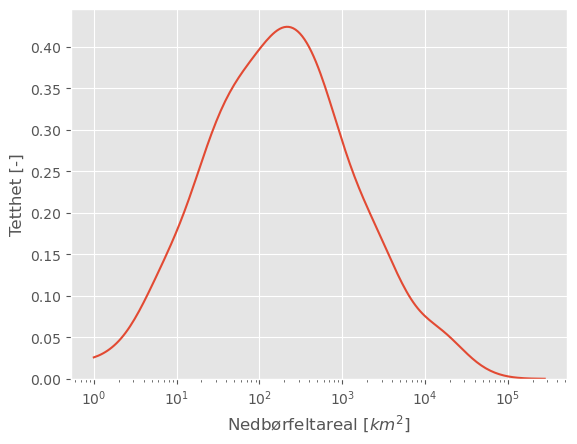

In [10]:
# Join modelled and observed data series
comp_df = pd.merge(
    mod_df[["regine", "year", "accum_q_m3/s"]],
    obs_q_df,
    how="inner",
    on=["regine", "year"],
)

comp_stn_df = comp_df[
    [
        "station_id",
        "station_name",
        "regine",
        "longitude",
        "latitude",
        "drainageBasinArea",
    ]
].drop_duplicates()

print("Number of unique stations with data:", len(comp_df["station_id"].unique()))
print("Number of annual flow estimates to compare:", len(comp_df))
ax = sn.kdeplot(comp_stn_df, x="drainageBasinArea", clip=(0, None), log_scale=True)
# ax.set_title("Distribution of NVE catchment areas")
ax.set_xlabel("Nedbørfeltareal [$km^2$]")
ax.set_ylabel("Tetthet [-]")
comp_df.head()

So, we have nearly 500 stations and more than 4000 annual discharge estimates in the period from 2013 to 2022. Based on the NVE data, most of these stations are monitoring small to medium catchments, typically a few hundred km2 in size. I believe these catchments will provide a good test for TEOTIL3, because simulating smaller catchments is likely to be most challenging for the model. This is because TEOTIL3 uses input data provided by NVE at vassdragsområde level (i.e. very large catchments), and I therefore expect TEOTIL3 to perform well for these (at least, as well as the NVE models). However, it may not perform so well at local scales, due to the model's simple approach for spatially distributing flows.

In [11]:
# Plot with ALtair
scatter = (
    alt.Chart(comp_df)
    .mark_circle(size=60)
    .encode(
        x=alt.X("obs_q_m3ps", title="Observed (m3/s)"),
        y=alt.Y("accum_q_m3/s", title="TEOTIL3 (m3/s)"),
        tooltip=["station_id", "station_name", "regine", "year"],
    )
    .properties(width=600, height=400)
)

line = (
    alt.Chart(comp_df).mark_line(color="black").encode(x="obs_q_m3ps", y="obs_q_m3ps")
)

chart = alt.layer(scatter, line).interactive()

chart

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [12]:
# Fit simple OLS model
model = smf.ols(formula="Q('accum_q_m3/s') ~ obs_q_m3ps", data=comp_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Q('accum_q_m3/s')   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 9.792e+04
Date:                Fri, 27 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:53:43   Log-Likelihood:                -17721.
No. Observations:                4318   AIC:                         3.545e+04
Df Residuals:                    4316   BIC:                         3.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6912      0.240     11.212      0.0

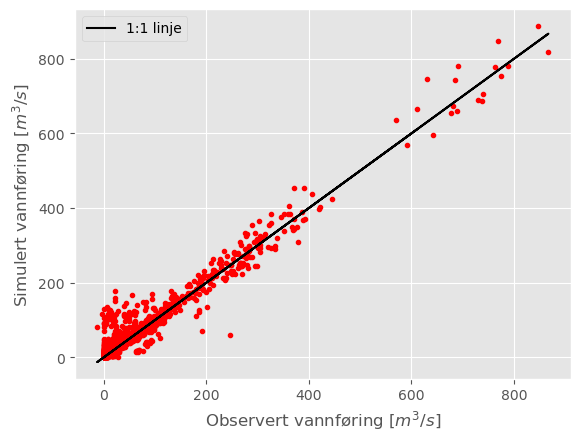

In [13]:
plt.plot(comp_df["obs_q_m3ps"], comp_df["accum_q_m3/s"], "ro", markersize=3)
plt.plot(comp_df["obs_q_m3ps"], comp_df["obs_q_m3ps"], "k-", label="1:1 linje")
plt.xlabel("Observert vannføring [$m^3/s$]")
plt.ylabel("Simulert vannføring [$m^3/s$]")
plt.legend()

On the whole, I am pleased with this result. With the exception of a small number of heavily regulated catchments, the model does an excellent job of predicting annual flows for small to medium catchments, as well as much larger ones. There is no obvious systematic bias and the fitted slope of 0.999 is far better than I had hoped!

**Note:** This is not an entirely independent check of TEOTIL3, as I assume a lot of the measured data is used by NVE when calibrating their original hydrology model. However, it is independent in the sense of comparing modelled against "real" measured data, and TEOTIL3 has never “seen” data from any of these catchments before.

#### 3.1.2. The JOVA catchments

NIBIO have expressed concerns that the new TEOTIL model overestimates runoff for the JOVA catchments (see e-mail from Sigrun received 13.11.2023 at 12.44). There is no obvious bias in the plot above (which compares against the NVE data). The code below explore the data provided by Sigrun.

The plot above suggests that, at site 'tim', the NIBIO discharge monitoring significantly underestimates flows compared to NVE's monitoring. I have no way of knowing which series is better, but for TEOTIL3 it is necessary to use the NVE data as no other organisation has a comprehensive national monitoring network.

After further investigation, I am quite confident that differences in runoff between TEOTIL3's estimates and NIBIO's JOVA data are due to differences between NVE's monitoring and NIBIO's monitoring within the same catchments (see e-mail sent to Sigrun 15.11.2023 at 11.24). This may eventually require further investigation, but for now I do not see any strong reasons to adjust/correct runoff estimates in TEOTIL3. 

#### 3.1.3. RID stations

The RID stations are all on big rivers with good long-term monitoring - especially for the "main" rivers.

In [14]:
# Get RID stations
# stn_xls = r"/home/jovyan/projects/rid/data/RID_Sites_List.xlsx"
# stn_df = pd.read_excel(stn_xls, sheet_name="RID_11")
stn_xls = r"/home/jovyan/projects/rid/data/RID_Sites_List_2017-2020.xlsx"
stn_df = pd.read_excel(stn_xls, sheet_name="RID_20")

# Assign to regines
reg_gdf = teo.io.get_regine_geodataframe(eng, end_yr)
stn_df = nivapy.spatial.identify_point_in_polygon(
    stn_df,
    reg_gdf,
    pt_col="station_id",
    poly_col="regine",
    lat_col="lat",
    lon_col="lon",
)

# Co-ords for some rivers plot in a side-regine (just). Manually assign regine
stn_df.loc[stn_df["station_id"] == 30019, "regine"] = "018.A"
stn_df.loc[stn_df["station_id"] == 29832, "regine"] = "027.A1"

# Pasvikelva (29819) and Tana should not be included in the comparison, as large
# contributions from outside Norway
stn_df = stn_df.query("station_id not in (29819, 29820)")

stn_df

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone,regine
0,30019,AAGEVEG,Vegårdselva,rid_108,rid_20,SKAGERAK,R,018.A322,58.669996,8.980983,6503307.00,498897.00,32,018.A
1,29612,BUSEDRA,Drammenselva,rid_11,rid_20,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.00,556695.00,32,012.A3
2,29779,FINEALT,Altaelva,rid_11,rid_20,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.00,586586.00,34,212.A0
5,29821,HOREVOS,Vosso (Bolstadelvi),rid_11,rid_20,NORTH SEA,R,062.C1,60.647000,6.112000,6726970.00,342124.00,32,062.C11
6,29822,MROEDRI,Driva,rid_36,rid_20,NORWEGIAN SEA2,R,109.A0,62.668999,8.570990,6948784.00,478024.00,32,109.A0
7,29782,NOREVEF,Vefsna,rid_11,rid_20,NORWEGIAN SEA2,R,151.A4,65.749000,13.239000,7293064.00,419297.00,33,151.A4
8,36225,OSLEALN,Alna,rid_11,rid_20,SKAGERAK,R,006.2A0,59.905091,10.791359,6642144.00,600213.00,32,006.2A0
9,29832,ROGEBJE,Bjerkreimselva,rid_36,rid_20,NORTH SEA,R,027.A21,58.478994,5.994986,6485932.00,674624.00,31,027.A1
10,29783,ROGEORR,Orreelva,rid_11,rid_20,NORTH SEA,R,028.4A,58.731000,5.529000,6512861.00,646406.00,31,028.4A
11,29837,ROGEVIK,Vikedalselva,rid_36,rid_20,NORTH SEA,R,038.A0,59.499993,5.909988,6599334.00,664721.00,31,038.A0


In [15]:
# Get observed flow and chem
obs_csv = r"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/loads_and_flows_rid_20_1990-2022.csv"
obs_df = pd.read_csv(obs_csv)

# Get cols of interest
id_cols = ["station_id", "year"]
q_pars = ["mean_q_1000m3/day"]
chem_pars = ["NO3-N", "NH4-N", "TOTN", "PO4-P", "TOTP", "TOC", "SPM"]
cols = (
    id_cols
    + q_pars
    + [f"{i}_tonnes" for i in chem_pars]
    + [f"{i}_Est" for i in chem_pars]
)
obs_df = obs_df[cols]

# Period of interest
obs_df = obs_df.query("@st_yr <= year <= @end_yr")

# Remove statistical estimates
for par in chem_pars:
    obs_df[f"{par}_tonnes"] = obs_df[f"{par}_tonnes"].where(obs_df[f"{par}_Est"] == 0)
    del obs_df[f"{par}_Est"]
obs_df = obs_df.melt(id_vars=id_cols).dropna()

# Remove data from Altaelva in 2014, 2021 and 2022. P and SS flux estimates for these years are incredibly high.
# This is due to the sampling catching a huge meltwater pulse with very high sediment concentrations. For example,
# the sample collected in June 2022 has a SS concentration of 255 mg/l at a discharge of 640 m3/s. This leads to
# annual flux estimates more an order of magnitude bigger than in other years. The data may be correct, but it
# is unlikely to be representative of the entire month, as assumed by the RID calculations. These data should
# therefore be omitted from the evaluation.
obs_df = obs_df[
    ~((obs_df["station_id"] == 29779) & obs_df["year"].isin([2014, 2021, 2022]))
]
obs_df.head()

,station_id,year,variable,value
0,30019,2013,mean_q_1000m3/day,1091.548794
1,30019,2014,mean_q_1000m3/day,1703.042338
2,30019,2015,mean_q_1000m3/day,1197.751088
3,30019,2016,mean_q_1000m3/day,918.154463
4,30019,2017,mean_q_1000m3/day,1130.149148


In [16]:
# Filter to stations with observed data
stn_list = list(obs_df["station_id"].unique())
stn_df = stn_df.query("station_id in @stn_list")

# Get model results
df_list = []
for idx, row in stn_df.iterrows():
    reg_id = row["regine"]
    stn_res_df = mod_df.query("regine == @reg_id").copy()
    stn_res_df["mean_q_1000m3/day"] = stn_res_df["accum_q_m3/s"] * 60 * 60 * 24 / 1000
    stn_res_df["station_id"] = row["station_id"]
    stn_res_df = stn_res_df[["station_id", "year", "mean_q_1000m3/day"]].melt(
        id_vars=id_cols
    )
    df_list.append(stn_res_df)
rid_mod_df = pd.concat(df_list, axis="rows")

comp_df = pd.merge(
    rid_mod_df,
    obs_df,
    how="left",
    on=["station_id", "year", "variable"],
    suffixes=("_mod", "_obs"),
)
comp_df.head()

,station_id,year,variable,value_mod,value_obs
0,30019,2013,mean_q_1000m3/day,1145.127024,1091.548794
1,30019,2014,mean_q_1000m3/day,1786.635619,1703.042338
2,30019,2015,mean_q_1000m3/day,1256.542243,1197.751088
3,30019,2016,mean_q_1000m3/day,963.221674,918.154463
4,30019,2017,mean_q_1000m3/day,1185.622272,1130.149148


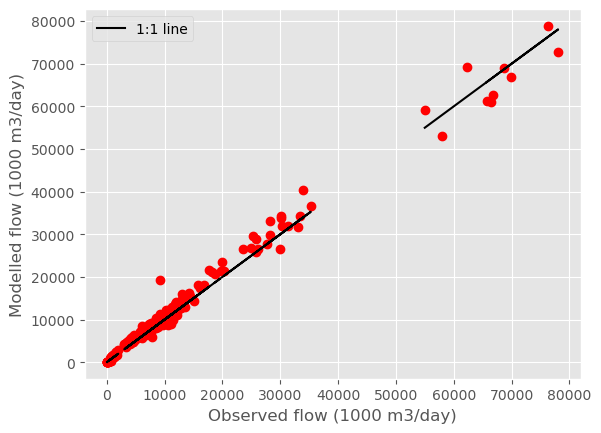

In [17]:
# Scatterplot
plt.plot(comp_df["value_obs"], comp_df["value_mod"], "ro")
plt.plot(comp_df["value_obs"], comp_df["value_obs"], "k-", label="1:1 line")
plt.xlabel("Observed flow (1000 m3/day)")
plt.ylabel("Modelled flow (1000 m3/day)")
plt.legend(loc="best")

In [18]:
# Convert to long
comp_df = comp_df.melt(id_vars=["station_id", "year", "variable"], var_name="model")
comp_df["model"] = comp_df["model"].str.replace("value_", "")
comp_df.head()

,station_id,year,variable,model,value
0,30019,2013,mean_q_1000m3/day,mod,1145.127024
1,30019,2014,mean_q_1000m3/day,mod,1786.635619
2,30019,2015,mean_q_1000m3/day,mod,1256.542243
3,30019,2016,mean_q_1000m3/day,mod,963.221674
4,30019,2017,mean_q_1000m3/day,mod,1185.622272


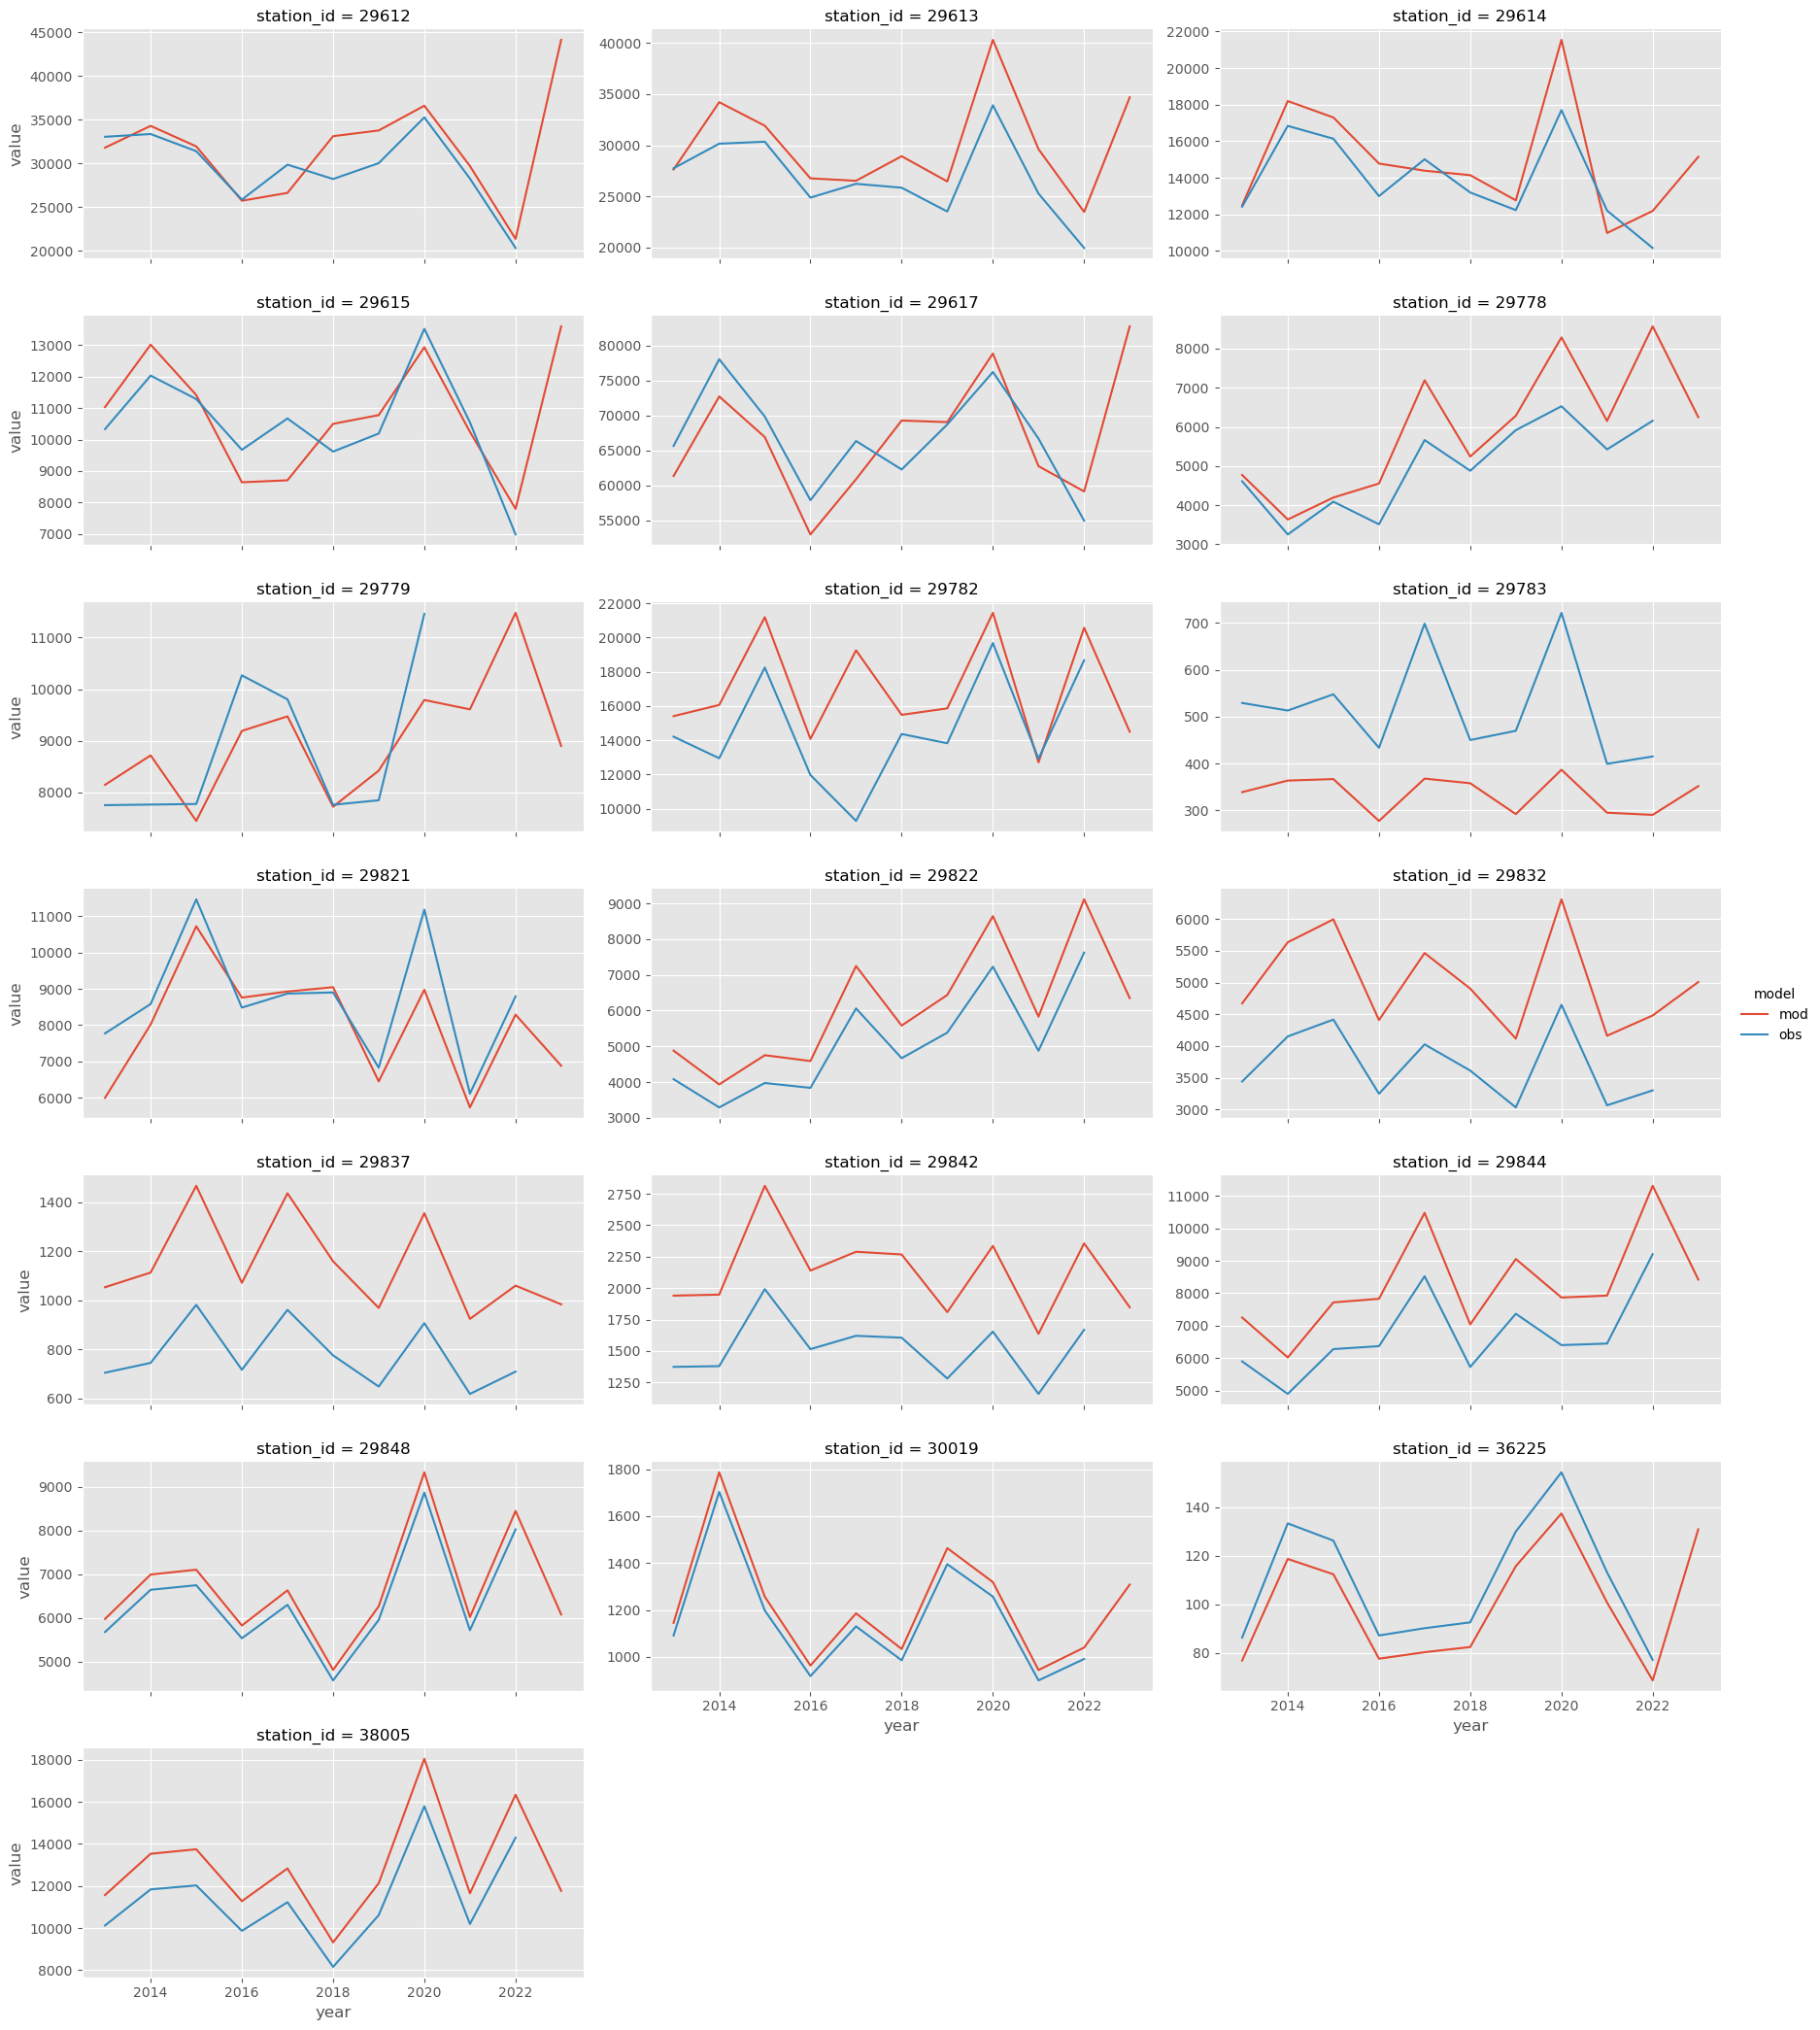

In [19]:
# Time series plots
sn.relplot(
    comp_df,
    x="year",
    y="value",
    hue="model",
    col="station_id",
    col_wrap=3,
    height=3,
    aspect=2,
    kind="line",
    facet_kws={"sharey": False},
)

In general TEOTIL3 performs well. The only station where modelled discharges are substantially different to those actually measured is 29783 (Orreelva in Rogaland). However, in the RID programme, "observed" series for this station are actually area-scaled from a neighbouring catchment (Haugland on Håånaelva), which is some distance to the south and considerably larger and more mountainous (whereas Orreelva is relatively flat). I therefore suspect TEOTIL3's estimates might be as good or better than the "observed" estimates for this site (which are actually observed somewhere else).

### 3.2. Chemical fluxes

The code in this section considers chemical fluxes from the main RID rivers, plus selected other rivers in Vannmiljø.

#### 3.2.1. RID sites

Observed fluxes for the RID rivers are already compiled, but are restructured below.

In [20]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text

In [21]:
obs_df = obs_df.pivot(
    index=["station_id", "year"], columns="variable", values="value"
).reset_index()

obs_df["DIN_tonnes"] = obs_df["NH4-N_tonnes"] + obs_df["NO3-N_tonnes"]
obs_df["TON_tonnes"] = obs_df["TOTN_tonnes"] - obs_df["DIN_tonnes"]
obs_df["TDP_tonnes"] = obs_df["PO4-P_tonnes"]
obs_df["TPP_tonnes"] = obs_df["TOTP_tonnes"] - obs_df["PO4-P_tonnes"]
obs_df["SS_tonnes"] = obs_df["SPM_tonnes"]
obs_df.drop(
    columns=[
        "NH4-N_tonnes",
        "NO3-N_tonnes",
        "PO4-P_tonnes",
        "SPM_tonnes",
        "mean_q_1000m3/day",
    ],
    inplace=True,
)

obs_df = pd.merge(obs_df, stn_df[["station_id", "regine"]], how="left", on="station_id")
obs_df.dropna(subset="regine", inplace=True)
obs_df

,station_id,year,TOC_tonnes,TOTN_tonnes,TOTP_tonnes,DIN_tonnes,TON_tonnes,TDP_tonnes,TPP_tonnes,SS_tonnes,regine
0,29612,2013,43176.070303,6098.750969,110.922952,4010.791592,2087.959376,58.874842,52.048110,61309.068501,012.A3
1,29612,2014,41318.138144,5116.832513,72.148616,3042.674387,2074.158125,35.062635,37.085981,26950.842127,012.A3
2,29612,2015,48039.461602,5377.623798,140.256422,2804.338888,2573.284911,80.151248,60.105174,75262.588402,012.A3
3,29612,2016,34030.477567,4262.550742,91.888625,2442.347876,1820.202866,49.513580,42.375044,40996.042715,012.A3
4,29612,2017,41294.356441,4256.075385,67.884941,2722.080901,1533.994484,26.224012,41.660929,20771.380729,012.A3
...,...,...,...,...,...,...,...,...,...,...,...
202,38005,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.A6
203,38005,2019,4380.379561,490.032271,14.813233,261.677013,228.355259,10.770730,4.042503,9064.904899,196.A6
204,38005,2020,18940.079596,735.388153,53.395056,310.843634,424.544519,42.722739,10.672317,54876.480420,196.A6
205,38005,2021,5034.071049,565.688419,21.935841,158.919154,406.769265,18.146850,3.788991,18719.904527,196.A6


#### 3.2.2. Vannmiljø

As part of the Oslofjord modelling project, Phil has exported data from Vannmiljø and standardised the parameter names. He has also done some basic quality checking and added flags to the data - see `info_river_VM_FRESH_23102023.txt` for details.

This section searches Phil's dataset for sites with near-complete data and nearby NVE monitoring. These datasets are used to estimate loads, which are then appended to the observed RID fluxes above.

In [22]:
# Phil's data period
vm_st_yr, vm_end_yr = 2017, 2021

# Read Phil's Vannmiljø export
csv_path = r"/home/jovyan/shared/common/oslofjord_modelling/colocated_VM_FRESH_23102023/river_VM_FRESH_23102023_update13032024.csv"
vm_df = pd.read_csv(csv_path)

# Filter to pars and period of interest
par_list = ["TOTN", "NO3N", "NO3NO2N", "NH4N", "TOTP", "TDP", "TOC", "SPM", "TSM"]
id_cols = [
    "year",
    "month",
    "day",
    "hour",
    "td",
    "lat",
    "lon",
    "depth",
    "Vannlokalitet_kode",
    "Vannlokalitet",
]
vm_df = vm_df.query("@vm_st_yr <= year <= @vm_end_yr")
keep_cols = []
for par in par_list:
    par_cols = [col for col in vm_df.columns if col.split("_")[0] == par]
    assert len(par_cols) == 1
    par_col = par_cols[0]
    flag_col = f"{par}f"
    assert flag_col in vm_df.columns

    # Just keep data with quality flag = 0 (i.e. no obvious issues)
    vm_df.loc[vm_df[flag_col] != 0, par_col] = np.nan
    keep_cols.append(par_col)

vm_df = vm_df[id_cols + keep_cols]

# Aggregate VM pars to match TEOTIL (roughly)
# If DIN > TOTN or TDP > TOTP, set fraction equal to total
vm_df["NO3NO2N_ugNpl"].fillna(vm_df["NO3N_ugNpl"], inplace=True)
vm_df["TSM_mgpl"].fillna(vm_df["SPM_mgpl"], inplace=True)
vm_df["DIN_ugNpl"] = vm_df["NO3NO2N_ugNpl"] + vm_df["NH4N_ugNpl"]
vm_df.loc[vm_df["DIN_ugNpl"] > vm_df["TOTN_ugNpl"], "DIN_ugNpl"] = vm_df["TOTN_ugNpl"]
vm_df.loc[vm_df["TDP_ugPpl"] > vm_df["TOTP_ugPpl"], "TDP_ugPpl"] = vm_df["TOTP_ugPpl"]
vm_df["TON_ugNpl"] = vm_df["TOTN_ugNpl"] - vm_df["DIN_ugNpl"]
vm_df["TPP_ugPpl"] = vm_df["TOTP_ugPpl"] - vm_df["TDP_ugPpl"]
vm_df["SS_mgpl"] = vm_df["TSM_mgpl"]
vm_df.drop(
    columns=["NO3N_ugNpl", "NO3NO2N_ugNpl", "NH4N_ugNpl", "SPM_mgpl", "TSM_mgpl"],
    inplace=True,
)

# Keep only samples with complete data for all pars
vm_df.dropna(how="any", inplace=True)

# Get unique stations and assign to regines
vm_stn_df = vm_df[
    ["lat", "lon", "Vannlokalitet_kode", "Vannlokalitet"]
].drop_duplicates()
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)
vm_stn_df = nivapy.spatial.identify_point_in_polygon(
    vm_stn_df,
    reg_gdf,
    pt_col="Vannlokalitet_kode",
    poly_col="regine",
    lat_col="lat",
    lon_col="lon",
)

display(vm_stn_df.head())
display(vm_df.head())

/tmp/ipykernel_4628/3625756651.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  vm_df["NO3NO2N_ugNpl"].fillna(vm_df["NO3N_ugNpl"], inplace=True)
/tmp/ipykernel_4628/3625756651.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

,lat,lon,Vannlokalitet_kode,Vannlokalitet,regine
0,62.955192,10.729534,122-28051,Gaula ved Singsåsbrua (G7),122.E40
1,59.937570,9.942696,012-28216,Snarumselva ved Formo,012.CA1
2,59.425778,9.988823,015-28488,Numedalslågen ved Brufoss,015.C31
3,60.214057,11.356139,002-30582,Vorma ved Svanfoss (V3),002.DA3
4,69.208040,18.476686,04.02-31009,Målselva ved Gullhavøra,196.A31


,year,month,day,hour,td,lat,lon,depth,Vannlokalitet_kode,Vannlokalitet,TOTN_ugNpl,TOTP_ugPpl,TDP_ugPpl,TOC_mgCpl,DIN_ugNpl,TON_ugNpl,TPP_ugPpl,SS_mgpl
2610,2018,2,5,10,737096.416667,62.955192,10.729534,0.0,122-28051,Gaula ved Singsåsbrua (G7),285.0,2.0,1.0,1.8,175.0,110.0,1.0,0.33
2611,2018,3,5,10,737124.416667,62.955192,10.729534,0.0,122-28051,Gaula ved Singsåsbrua (G7),410.0,4.0,2.0,1.3,285.0,125.0,2.0,0.53
2612,2018,4,3,15,737153.625000,62.955192,10.729534,0.0,122-28051,Gaula ved Singsåsbrua (G7),325.0,2.0,1.0,1.7,272.0,53.0,1.0,0.50
3964,2017,5,9,13,736824.541667,59.937570,9.942696,0.0,012-28216,Snarumselva ved Formo,175.0,2.0,1.0,2.0,94.0,81.0,1.0,0.92
3965,2017,6,6,0,736852.000000,59.937570,9.942696,0.0,012-28216,Snarumselva ved Formo,200.0,6.0,2.0,3.7,56.0,144.0,4.0,2.15


#### Link to NVE discharge

In [23]:
def has_discharge(row):
    if "Vannføring" in str(row["seriesList"]):
        return 1
    else:
        return 0


def find_nearest(row, df):
    lat_lon = row["lat"], row["lon"]
    regine = row["regine"]
    df = df.query("regine == @regine")
    min_distance = None
    nearest_station_id = None
    for idx, row in df.iterrows():
        distance = geodesic((row["lat"], row["lon"]), lat_lon).miles
        if min_distance is None or distance < min_distance:
            min_distance = distance
            nearest_station_id = row["station_id"]
    return nearest_station_id


# Get all NVE stations with discharge data
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df["has_q"] = nve_stn_df.apply(has_discharge, axis=1)
nve_stn_df = nve_stn_df.query("has_q  == 1")

# For each chenmistry station, find the nearest NVE station, but only considering stations
# within the same regine
cols = [
    "station_id",
    "station_name",
    "latitude",
    "longitude",
    "regineNo",
    "drainageBasinArea",
]
nve_stn_df = nve_stn_df[cols]
nve_stn_df.rename(
    columns={
        "latitude": "lat",
        "longitude": "lon",
        "regineNo": "regine",
        "drainageBasinArea": "catch_area_km2",
    },
    inplace=True,
)
vm_stn_df["nve_station_id"] = vm_stn_df.apply(find_nearest, args=(nve_stn_df,), axis=1)
vm_stn_df.dropna(inplace=True)

# Remove Driva, as HyAPI data suddenly looks strange
vm_stn_df = vm_stn_df.query("nve_station_id != '109.42.0'")

print(len(vm_stn_df), "Vannmiljø stations have an NVE station in the same regine.")
vm_stn_df

15 Vannmiljø stations have an NVE station in the same regine.


,lat,lon,Vannlokalitet_kode,Vannlokalitet,regine,nve_station_id
5,59.198077,9.611351,016-38513,Skienselva ved Klosterfossen,016.A221,16.521.0
12,63.432799,10.405892,123-38525,Nidelva (Trøndelag) ved Bakke bru,123.A2,123.38.0
24,58.143142,7.545620,022-38529,Mandalselva ved Holmesland,022.A6,22.4.0
27,59.498755,5.910276,038-38547,Vikedalselva,038.A0,38.1.0
32,61.058487,12.592578,311-43773,Trysilelva ved Lutnes,311.A52,311.21.0
37,59.904718,10.791568,006-51733,"Alna, hovedmålestasjon ALN 6",006.2A0,6.78.0
41,63.068796,10.275139,122-80127,Gaula ved Rostaden (G13),122.B3,122.9.0
42,58.294806,6.448145,026-85391,Sira nedstrøms Logsfossen,026.A,26.31.0
43,59.930560,10.842638,006-86181,Alna ved Alnabru,006.2B0,6.12.0
45,59.885462,9.910386,012-90005,Drammenselva ved Døvikfossen,012.B63,12.285.0


**The discharge stations identified above are not necessarily suitable and need to be checked manually**. Using the table above as a starting point, I have used Vannmiljø and NVE Atlas to manually link VM stations to NVE IDs. Results are saved in `link_vannmiljo_nve_stations.csv`

In [24]:
# Read linking table
csv_path = os.path.join(eval_fold, "link_vannmiljo_nve_stations.csv")
link_df = pd.read_csv(csv_path)

# Remove auto-assigned IDs and use manually curated ones instead
del vm_stn_df["nve_station_id"]
vm_stn_df = pd.merge(vm_stn_df, link_df, on="Vannlokalitet_kode", how="inner")

# Filter chem to just the stations of interest
stn_id_list = vm_stn_df["Vannlokalitet_kode"].unique().tolist()
vm_df = vm_df.query("Vannlokalitet_kode in @stn_id_list")

#### Calculate catchment areas

For estimating observed fluxes, I will scale the discharge data by the ratio of catchment areas.

In [25]:
# Derive catchment boundaries for chem and Q stations
nve_id_list = vm_stn_df["nve_station_id"].unique().tolist()
nve_stn_df = nve_stn_df.query("station_id in @nve_id_list")

vm_stn_gdf = nivapy.spatial.derive_watershed_boundaries(
    vm_stn_df,
    id_col="Vannlokalitet_kode",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
vm_stn_gdf["chem_area_km2"] = vm_stn_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

nve_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=20,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
nve_gdf["q_area_km2"] = nve_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
nve_gdf["nve_station_id"] = nve_gdf["station_id"]

# Join areas back to 'stn_df' and compare to NVE values for the Q stations (from HydAPI)
vm_stn_df = pd.merge(
    vm_stn_df,
    vm_stn_gdf[["Vannlokalitet_kode", "chem_area_km2"]],
    how="left",
    on="Vannlokalitet_kode",
)
vm_stn_df = pd.merge(
    vm_stn_df,
    nve_gdf[["nve_station_id", "q_area_km2", "catch_area_km2"]],
    how="left",
    on="nve_station_id",
)

vm_stn_df

Connection successful.


Looping over vassdragsområder:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 006:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 018:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 038:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 109:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 122:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 123:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 128:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 311:   0%|          | 0/1 [00:00<?, ?it/s]

Connection successful.


Looping over vassdragsområder:   0%|          | 0/8 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 006:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 018:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 038:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 109:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 122:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 123:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 128:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 311:   0%|          | 0/1 [00:00<?, ?it/s]

,lat,lon,Vannlokalitet_kode,Vannlokalitet,regine,nve_station_id,chem_area_km2,q_area_km2,catch_area_km2
0,63.432799,10.405892,123-38525,Nidelva (Trøndelag) ved Bakke bru,123.A2,123.20.0,3112.090203,3052.219755,3057.88
1,59.498755,5.910276,038-38547,Vikedalselva,038.A0,38.1.0,116.379113,115.919320,116.88
2,61.058487,12.592578,311-43773,Trysilelva ved Lutnes,311.A52,311.6.0,5259.583401,4449.778108,4424.85
3,63.068796,10.275139,122-80127,Gaula ved Rostaden (G13),122.B3,122.9.0,3060.104724,3085.825119,3085.86
4,59.930560,10.842638,006-86181,Alna ved Alnabru,006.2B0,6.78.0,41.158783,64.463253,53.03
5,58.669421,8.980143,018-90047,Vegårdselva,018.A,18.4.0,406.152841,406.063436,407.37
6,62.556263,9.113777,109-96135,Driva ved Gjøra,109.C0,109.20.0,1661.303104,1626.011263,1630.25
7,64.019296,11.686405,128-96153,Ogna ved Branseggfossen,128.AA3,128.5.0,489.165279,477.070392,477.08


#### Estimate annual fluxes

Based on the plots above, I will use the Vannmiljø chemistry and the NVE discharge data to estimate observed annual fluxes. There is quite a lot of noise in the chemistry data, but it will nevertheless be an interesting comparison.

In [26]:
# Plot raw Vannmiljø and NVE data series
# Takes a long time to complete (~5 mins)
par_list = [
    "TOTN_ugNpl",
    "TOTP_ugPpl",
    "TDP_ugPpl",
    "TOC_mgCpl",
    "DIN_ugNpl",
    "TON_ugNpl",
    "TPP_ugPpl",
    "SS_mgpl",
]

In [27]:
# Estimate annual fluxes
df_list = []
for idx, row in vm_stn_df.iterrows():
    vm_id = row["Vannlokalitet_kode"]
    nve_id = row["nve_station_id"]
    area_fac = row["chem_area_km2"] / row["q_area_km2"]

    # Get chem data for station
    chem_stn_df = vm_df.query("Vannlokalitet_kode == @vm_id").copy()
    chem_stn_df["datetime"] = pd.to_datetime(
        chem_stn_df[["year", "month", "day", "hour"]]
    )
    chem_stn_df.set_index("datetime", inplace=True)
    chem_stn_df = chem_stn_df[par_list].resample("D").mean().dropna()

    # Convert units in column names to the format expected by nivapy
    chem_stn_df.columns = [col.replace("Npl", "/l") for col in chem_stn_df.columns]
    chem_stn_df.columns = [col.replace("Ppl", "/l") for col in chem_stn_df.columns]
    chem_stn_df.columns = [col.replace("Cpl", "/l") for col in chem_stn_df.columns]
    chem_stn_df.columns = [col.replace("pl", "/l") for col in chem_stn_df.columns]

    # Get flow data for stations
    q_stn_df = nivapy.da.query_nve_hydapi(
        [nve_id], [1001], f"{vm_st_yr}-01-01", f"{vm_end_yr}-12-31", resolution=1440
    )
    q_stn_df = area_fac * q_stn_df.set_index("datetime")[["value"]].resample("D").mean()
    q_stn_df.index = q_stn_df.index.tz_localize(None)
    q_stn_df.rename(columns={"value": "flow_m3/s"}, inplace=True)

    # Calculate annual fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        q_stn_df,
        chem_stn_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
    )

    # Convert kg to tonnes
    flux_df = flux_df / 1000
    flux_df.columns = [col.replace("kg", "tonnes") for col in flux_df.columns]
    flux_df["Vannlokalitet_kode"] = vm_id
    df_list.append(flux_df)
flux_df = pd.concat(df_list, axis="rows")
flux_df = flux_df.reset_index()
flux_df = pd.merge(
    flux_df,
    vm_stn_df[["Vannlokalitet_kode", "regine"]],
    how="left",
    on="Vannlokalitet_kode",
)
flux_df.head()

/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is 

,year,TOTN_tonnes,TOTP_tonnes,TDP_tonnes,TOC_tonnes,DIN_tonnes,TON_tonnes,TPP_tonnes,SS_tonnes,Vannlokalitet_kode,regine
0,2017,727.027306,15.350150,7.568630,10205.163758,371.251900,355.775406,7.781520,8736.389213,123-38525,123.A2
1,2018,442.712093,7.344391,4.597558,5603.831241,226.402988,216.309104,2.746833,1112.017390,123-38525,123.A2
2,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123-38525,123.A2
3,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123-38525,123.A2
4,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123-38525,123.A2


#### 3.2.3. Compare modelled versus observed

In [28]:
# Combine data from Vannmiljø and RID stations
flux_df.rename(columns={"Vannlokalitet_kode": "station_id"}, inplace=True)
obs_df = pd.concat([obs_df, flux_df], axis="rows")

# Save for re-use later
# obs_csv = os.path.join(eval_fold, "rid_vannmiljo_obs_data_aggregated.csv")
# obs_df.to_csv(obs_csv, index=False)

In [29]:
# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
    del mod_df[col]

# Merge
comp_df = pd.merge(obs_df, mod_df, how="left", on=["regine", "year"])
comp_df.head()

,station_id,year,TOC_tonnes,TOTN_tonnes,TOTP_tonnes,DIN_tonnes,TON_tonnes,TDP_tonnes,TPP_tonnes,SS_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,29612,2013,43176.070303,6098.750969,110.922952,4010.791592,2087.959376,58.874842,52.048110,61309.068501,...,7.000318,1.319720,170.135236,1871.833506,7.075075,22180.284276,1010.618883,1180.754119,12.310292,5.235216
1,29612,2014,41318.138144,5116.832513,72.148616,3042.674387,2074.158125,35.062635,37.085981,26950.842127,...,7.547435,1.422445,183.454537,2018.350298,7.628907,23916.873938,1089.752158,1273.206695,13.272860,5.643953
2,29612,2015,48039.461602,5377.623798,140.256422,2804.338888,2573.284911,80.151248,60.105174,75262.588402,...,7.031071,1.325178,170.896424,1880.184380,7.106646,22279.507279,1015.149362,1186.045786,12.364693,5.258046
3,29612,2016,34030.477567,4262.550742,91.888625,2442.347876,1820.202866,49.513580,42.375044,40996.042715,...,5.665067,1.067861,137.674949,1514.703167,5.724380,17948.665674,817.819956,955.494905,9.959965,4.235584
4,29612,2017,41294.356441,4256.075385,67.884941,2722.080901,1533.994484,26.224012,41.660929,20771.380729,...,5.861468,1.104953,142.468438,1567.427065,5.924467,18573.358713,846.295039,988.763477,10.308051,4.383584


In [30]:
# comp_df = comp_df.query(
#     "station_id not in (29783, 29832, 29837, 29842, 36225, '006-86181', '038-38547', '038-58868')"
# )

In [31]:
# Get TEOTIL2 results
df_list = []
for year in range(st_yr, 2022):
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_output_data/teotil2_results_{year}.csv"
    teo2_df = pd.read_csv(url)
    teo2_df["year"] = year
    df_list.append(teo2_df)

teo2_df = pd.concat(df_list, axis="rows")
cols = [
    "regine",
    "year",
    "accum_all_sources_tot-n_tonnes",
    "accum_all_sources_tot-p_tonnes",
]
teo2_df = teo2_df[cols]
teo2_df.columns = teo2_df.columns.str.replace("accum_", "")
teo2_df.columns = teo2_df.columns.str.replace("tot-n", "totn")
teo2_df.columns = teo2_df.columns.str.replace("tot-p", "totp")
stn_reg_df = obs_df[["regine", "station_id"]].drop_duplicates()
teo2_df = pd.merge(teo2_df, stn_reg_df, how="left", on="regine")
teo2_df.dropna(subset="station_id", inplace=True)
teo2_df.head()

,regine,year,all_sources_totn_tonnes,all_sources_totp_tonnes,station_id
9668,038.A0,2013,124.980350,1.579552,29837
9669,038.A0,2013,124.980350,1.579552,038-38547
10469,006.2B0,2013,12.786194,3.428923,006-86181
10642,028.4A,2013,349.567275,2.175507,29783
11335,006.2A0,2013,19.173009,3.913192,36225


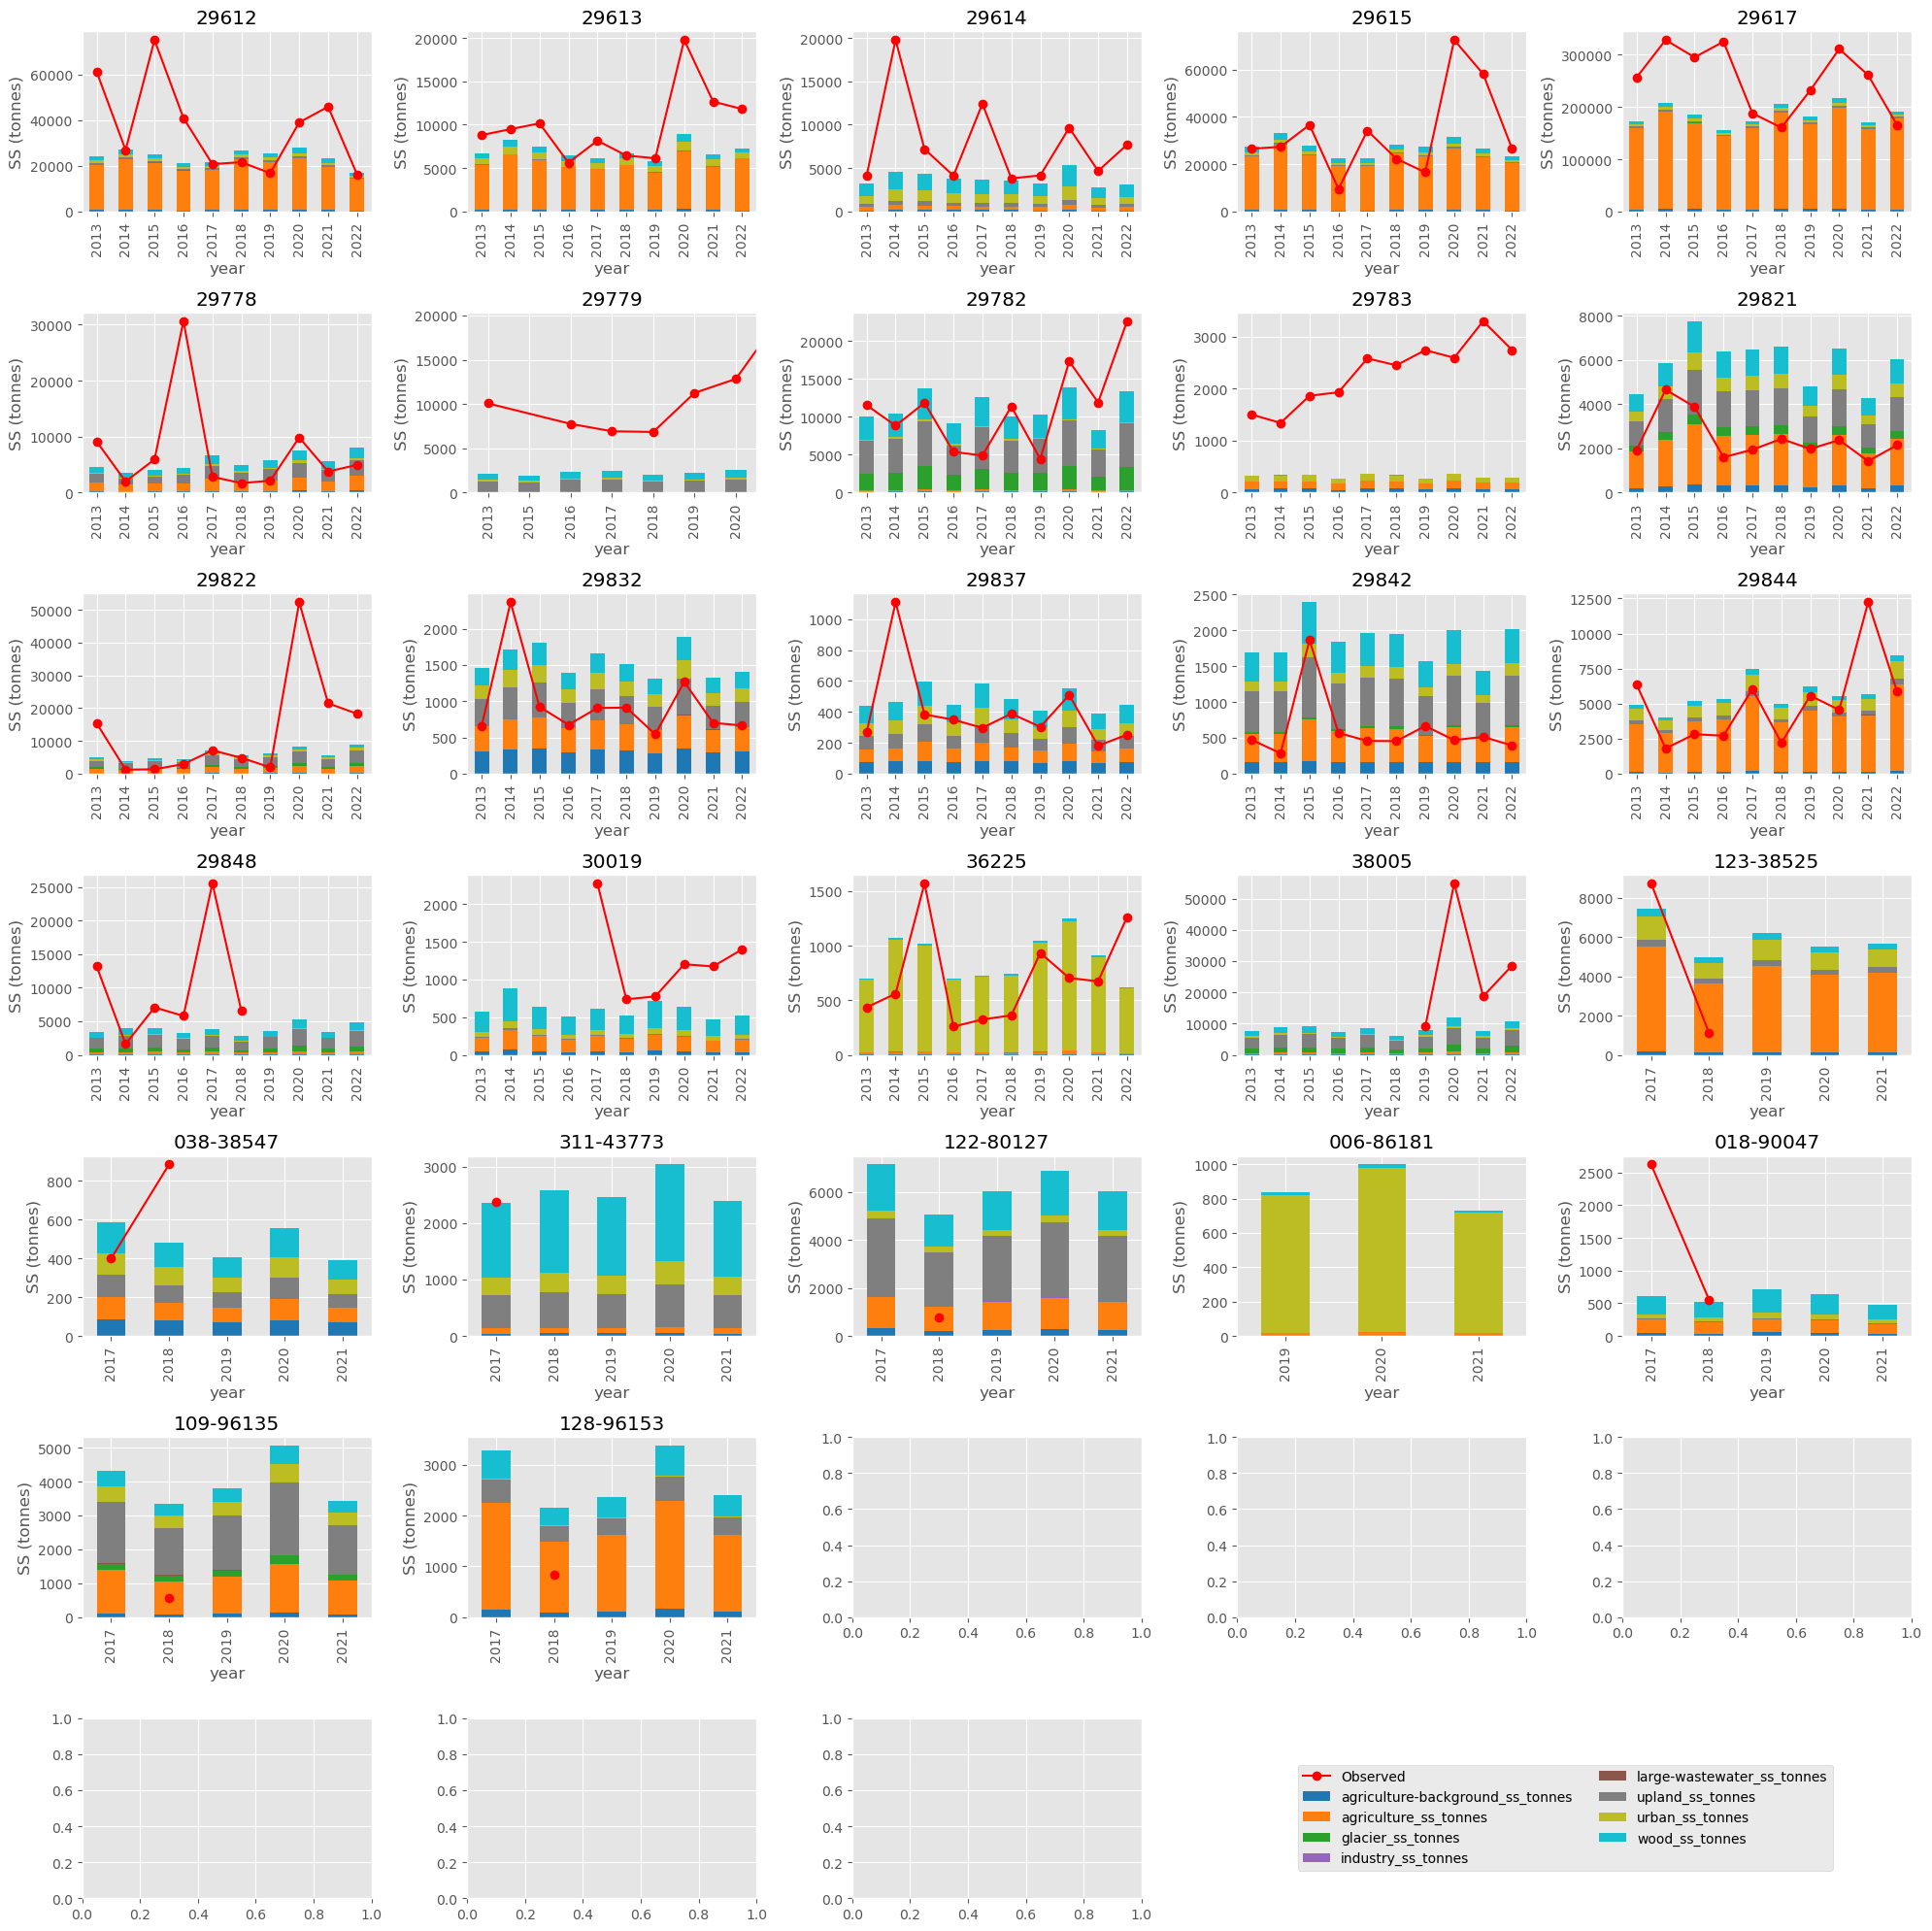

In [32]:
# Plot: single parameter per river
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
teo2_pars = ["TOTN", "TOTP"]
stn_list = comp_df["station_id"].unique().tolist()
par = "SS"

par_cols = [
    col for col in comp_df.columns if par.lower() in (i.lower() for i in col.split("_"))
]

fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

for idx, stn_id in enumerate(stn_list):
    stn_comp_df = comp_df.query("station_id == @stn_id").set_index("year")[par_cols]

    stn_comp_df.drop(columns=[f"{par}_tonnes"]).plot(
        kind="bar", stacked=True, ax=axes[idx], legend=False, cmap="tab10"
    )

    axes[idx].plot(
        stn_comp_df.index - stn_comp_df.index.min(),
        stn_comp_df[f"{par}_tonnes"],
        marker="o",
        color="red",
        label="Observed",
    )
    if par in teo2_pars:
        teo2_stn_df = teo2_df.query("station_id == @stn_id").set_index("year")
        axes[idx].plot(
            teo2_stn_df.index - teo2_stn_df.index.min(),
            teo2_stn_df[f"all_sources_{par.lower()}_tonnes"],
            marker="x",
            ls="none",
            color="black",
            label="TEOTIL2",
        )
    axes[idx].set_title(stn_id)
    axes[idx].set_ylabel(f"{par} (tonnes)")
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(0.95, 0.03), ncol=2)

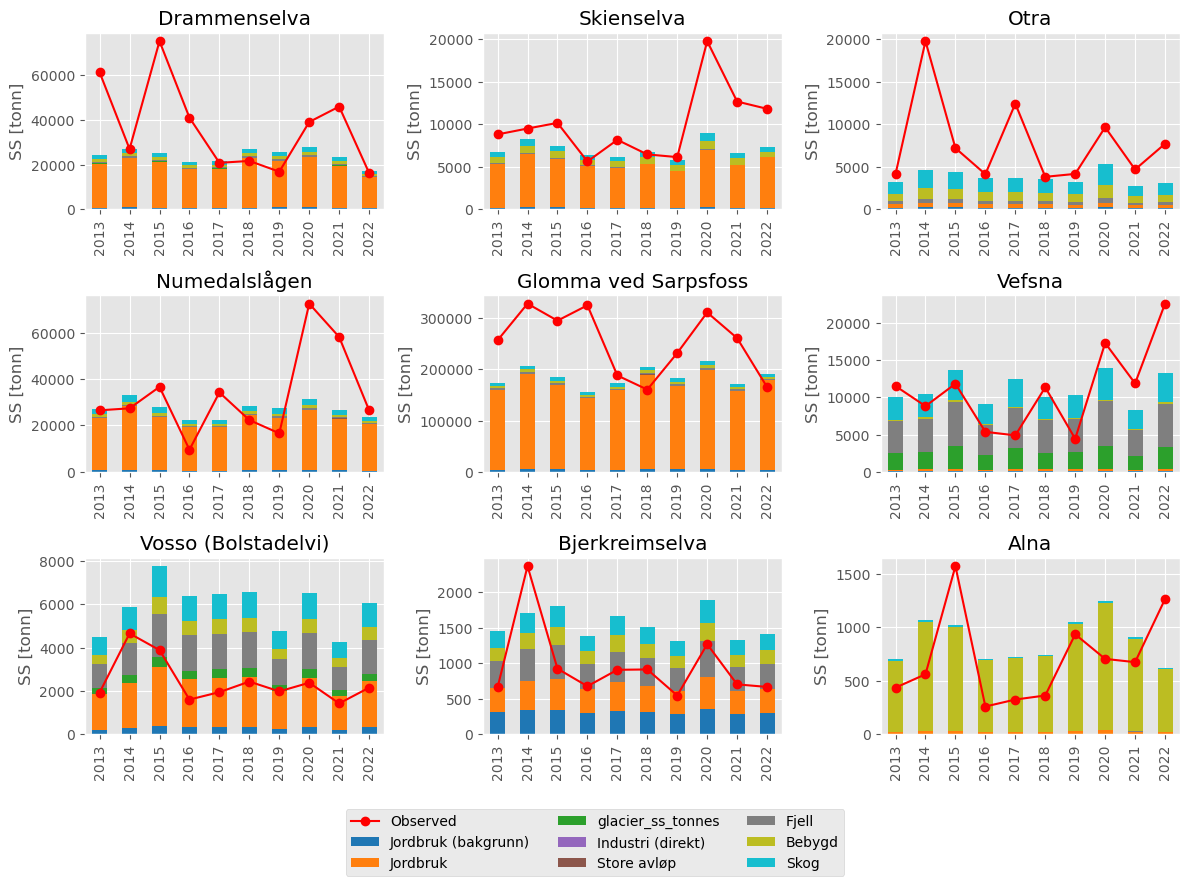

In [37]:
# Plot: single parameter per river for report
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]
teo2_pars = ["TOTN", "TOTP"]
stn_list = [29612, 29613, 29614, 29615, 29617, 29782, 29821, 29832, 36225]
par = "SS"

names_dict = {
    f"agriculture-background_{par.lower()}_tonnes": "Jordbruk (bakgrunn)",
    f"agriculture_{par.lower()}_tonnes": "Jordbruk",
    f"aquaculture_{par.lower()}_tonnes": "Akvakultur",
    f"industry_{par.lower()}_tonnes": "Industri (direkt)",
    f"lake_{par.lower()}_tonnes": "Avsetning til innsjø",
    f"large-wastewater_{par.lower()}_tonnes": "Store avløp",
    f"spredt_{par.lower()}_tonnes": "Spredt avløp",
    f"upland_{par.lower()}_tonnes": "Fjell",
    f"urban_{par.lower()}_tonnes": "Bebygd",
    f"wood_{par.lower()}_tonnes": "Skog",
}

par_cols = [
    col for col in comp_df.columns if par.lower() in (i.lower() for i in col.split("_"))
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for idx, stn_id in enumerate(stn_list):
    name = stn_df.query("station_id == @stn_id")["station_name"].iloc[0]
    stn_comp_df = comp_df.query("station_id == @stn_id").set_index("year")[par_cols]
    stn_comp_df.rename(columns=names_dict, inplace=True)
    stn_comp_df.drop(columns=[f"{par}_tonnes"]).plot(
        kind="bar", stacked=True, ax=axes[idx], legend=False, cmap="tab10"
    )
    axes[idx].plot(
        stn_comp_df.index - stn_comp_df.index.min(),
        stn_comp_df[f"{par}_tonnes"],
        marker="o",
        color="red",
        label="Observed",
    )
    if par in teo2_pars:
        teo2_stn_df = teo2_df.query("station_id == @stn_id").set_index("year")
        axes[idx].plot(
            teo2_stn_df.index - teo2_stn_df.index.min(),
            teo2_stn_df[f"all_sources_{par.lower()}_tonnes"],
            marker="x",
            ls="none",
            color="black",
            label="TEOTIL2",
        )
    axes[idx].set_title(name)
    axes[idx].set_ylabel(f"{par} [tonn]")
    axes[idx].set_xlabel("")
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, -0.06), ncol=3)
plt.savefig(
    f"updated_eval_bar_charts_{par.lower()}.png", dpi=200, bbox_inches="tight"
)

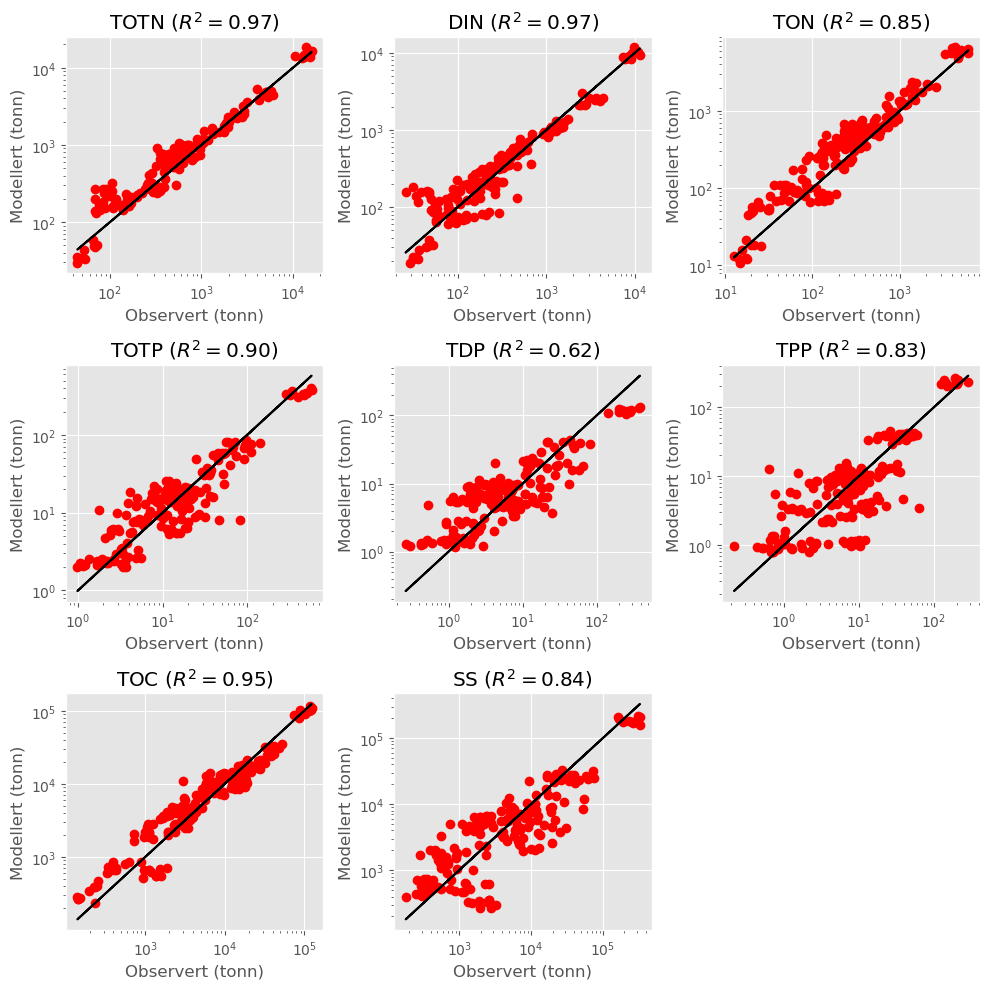

In [38]:
pars = ["TOTN", "DIN", "TON", "TOTP", "TDP", "TPP", "TOC", "SS"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flatten()
fig.delaxes(axes[-1])

for idx, par in enumerate(pars):
    par_cols = [
        col
        for col in comp_df.columns
        if par.lower() in (i.lower() for i in col.split("_"))
    ]
    reg_df = comp_df.set_index("year")[par_cols]
    obs = reg_df[f"{par}_tonnes"]
    mod = reg_df.drop(columns=[f"{par}_tonnes"]).sum(axis="columns")
    reg_df = pd.DataFrame({"mod": mod, "obs": obs}).query("(mod > 0) and (obs > 0)")
    r2 = r2_score(reg_df["obs"], reg_df["mod"])
    axes[idx].plot(reg_df["obs"], reg_df["mod"], "ro")
    axes[idx].plot(reg_df["obs"], reg_df["obs"], "k-", label="1:1 line")
    axes[idx].set_title(f"{par} ($R^2={r2:.2f}$)")
    # axes[idx].set_title(par)
    axes[idx].set_xlabel("Observert (tonn)")
    axes[idx].set_ylabel("Modellert (tonn)")
    axes[idx].set_xscale("log")
    axes[idx].set_yscale("log")
plt.tight_layout()
plt.savefig("updated_calibrated_performance_logged.png", dpi=200, bbox_inches="tight")